# Find long dead-end roads near a city in OpenStreetMap

Use the excellent [osmnx](https://osmnx.readthedocs.io/) and [networkx](https://networkx.org/) packages to download the road network of a city from OpenStreetMap and then find the longest dead-end roads in there.

In [1]:
import contextily
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx

from itertools import islice

%matplotlib inline

## Settings

Define your place of interest

In [2]:
PLACE = "Richmond, VA"

## Downloading the data

In [3]:
G = ox.graph_from_place(PLACE, network_type="drive")

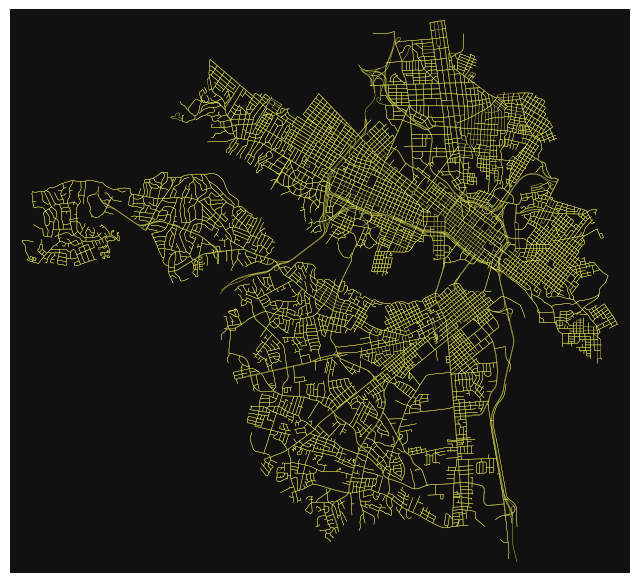

In [4]:
fig, ax = ox.plot_graph(G, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25)

## Find dead-end roads

A dead-end road is not part of a
[biconnected component](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.biconnected_components.html#networkx.algorithms.components.biconnected_components)
with at least 3 nodes.len

To find the dead-ends, iterate over the biconnected components and mark all their nodes. Any edge where at least one node is not marked, is part of a dead-end.

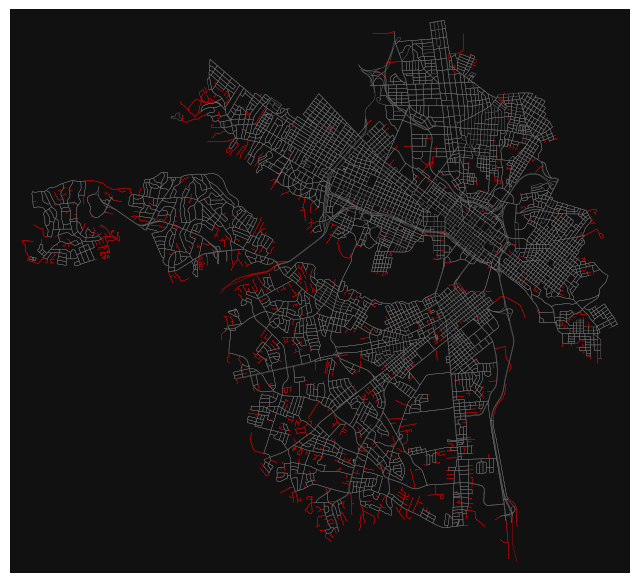

In [5]:
nodes_in_components = set()
for c in nx.biconnected_components(G.to_undirected()):
    if (len(c) > 3):
        nodes_in_components.update(c)

edge_color = ['grey' if (u in nodes_in_components and v in nodes_in_components) else 'red' for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=edge_color, edge_linewidth=0.25)

Filter the road network graph to only contain the dead-ends.

In [6]:
only_dead_ends = nx.subgraph_view(G, filter_edge=lambda u, v, k: u not in nodes_in_components or v not in nodes_in_components)

## Calculate length of dead-ends

Calculate the diameter of each dead-end. The diameter is the *longest* path among all *shortest* paths you can travel from any node to any other node.

In [7]:
dead_end_lengths = {}
for c in nx.connected_components(only_dead_ends.to_undirected()):
    if (len(c) <= 1):
        continue
    dead_end = G.subgraph(c).to_undirected()
    distance_matrix = {source: dict(nx.single_source_dijkstra_path_length(dead_end, source, weight="length")) for source in dead_end.nodes}
    eccentricity = nx.eccentricity(dead_end, sp=distance_matrix)
    diameter = nx.diameter(dead_end, e=eccentricity)
    dead_end_lengths[dead_end] = diameter

Sort dead-ends by length descending

In [8]:
dead_end_lengths = {k: v for k, v in sorted(dead_end_lengths.items(), key=lambda item: -item[1])}

## Plot the 10 longest dead-ends

As you can see, dead-ends are also generated when cutting roads at the city boundary.

To fix this one would need to get a larger area with a buffer around the city, identify the dead-ends and then filter for the city boundaries again.

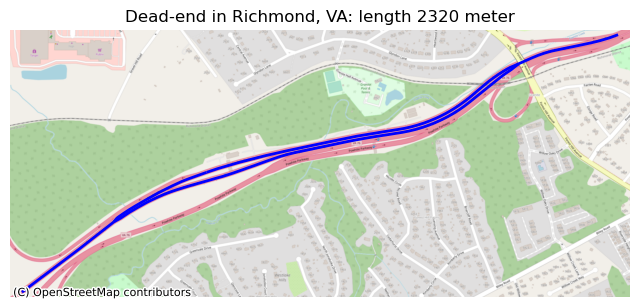

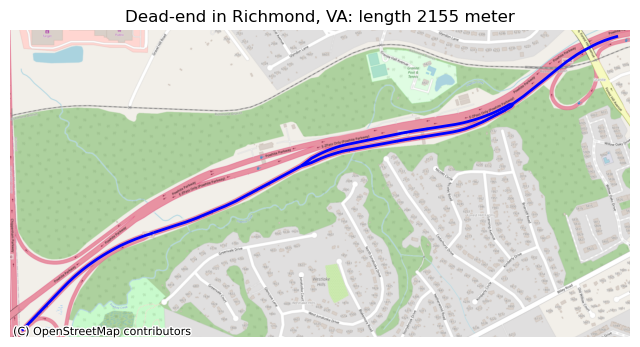

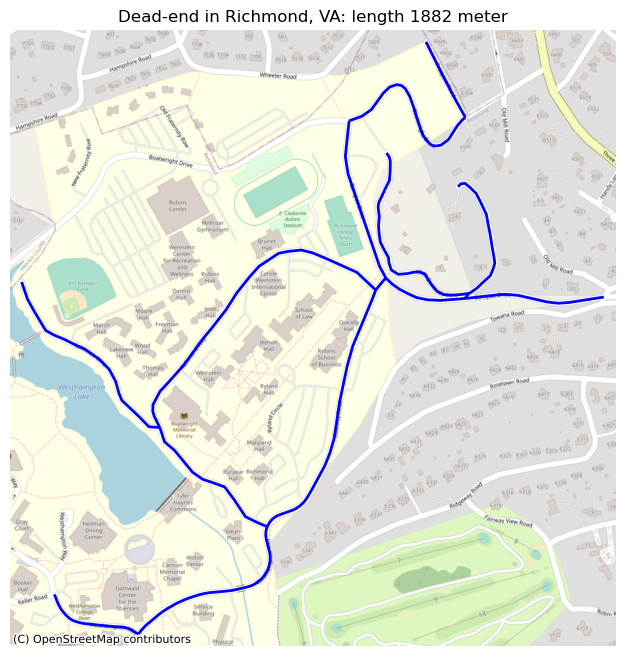

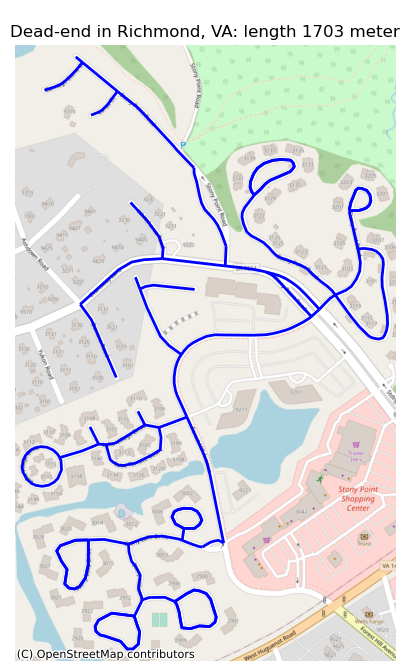

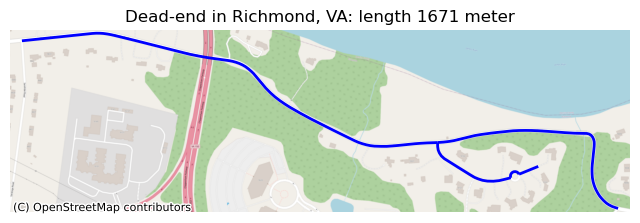

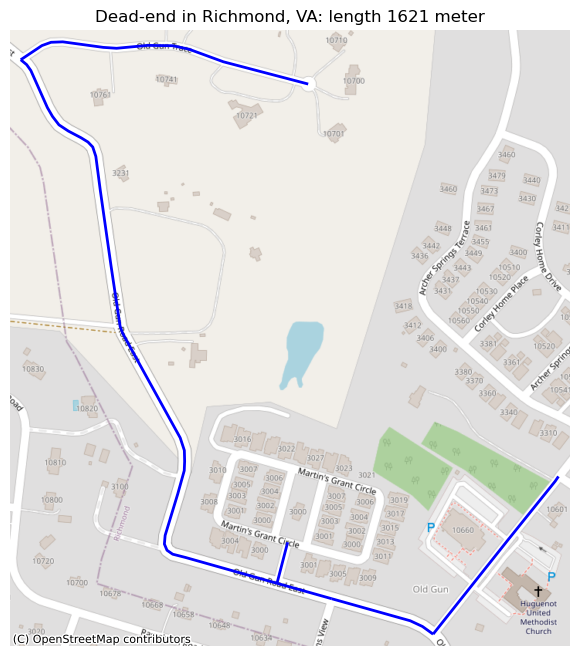

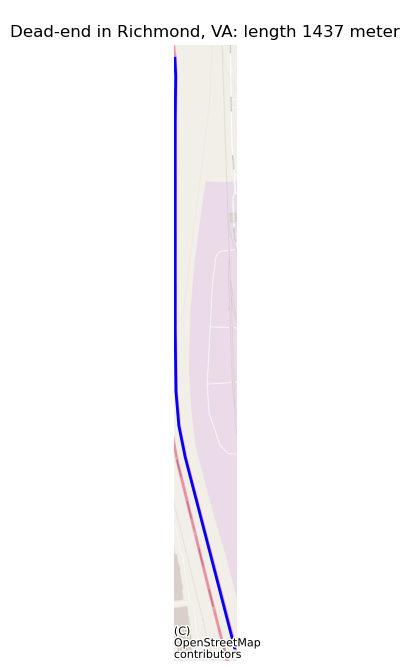

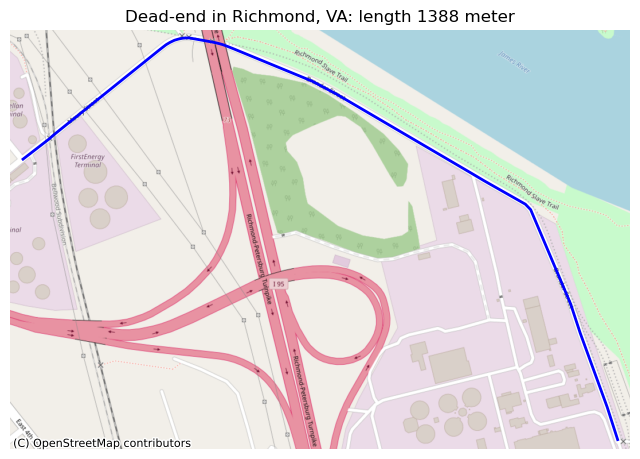

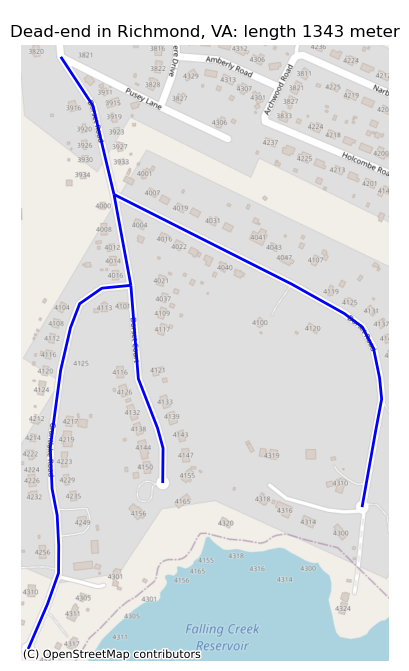

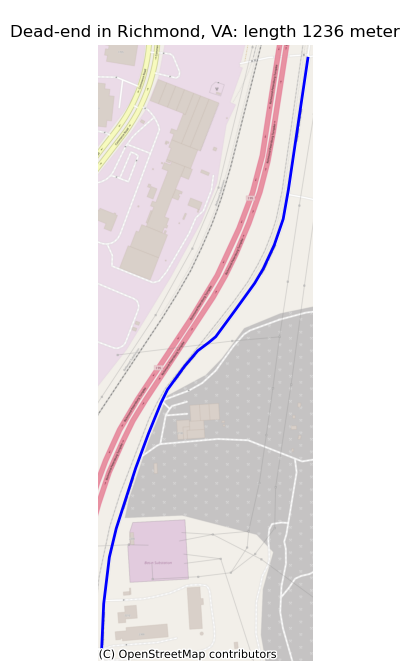

In [9]:
for dead_end, length in islice(dead_end_lengths.items(), 10):
    f,ax = plt.subplots(1,1, figsize=(8, 8))
    ox.plot_graph(ox.project_graph(dead_end, to_crs=3857), edge_linewidth=2, edge_color='blue', node_size=0, ax=ax, show=False)
    contextily.add_basemap(ax=ax, source=contextily.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Dead-end in {PLACE}: length {length:.0f} meter")